In [1]:
# project imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
# retrieve project data
csv_path1 = "Resources/drivers.csv"
csv_path2 = "Resources/races.csv"
csv_path3 = "Resources/lap_times.csv"
csv_path4 = "Resources/pit_stops.csv"
csv_path5 = "Resources/results.csv"
csv_path6 = "Resources/status.csv"

drivers_df = pd.read_csv(csv_path1)
races_df = pd.read_csv(csv_path2)
lap_df = pd.read_csv(csv_path3)
pit_df = pd.read_csv(csv_path4)
results_df = pd.read_csv(csv_path5)
status_df = pd.read_csv(csv_path6)

In [3]:
# combine the pitstop data with the results data
pitresults_df = pit_df.merge(results_df,how='inner',on=['raceId','driverId'],suffixes=["_pit",'_result'])
pitresults_df.head(10)

,raceId,driverId,stop,lap,time_pit,duration,milliseconds_pit,resultId,constructorId,number,...,positionOrder,points,laps,time_result,milliseconds_result,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,841,153,1,1,17:05:23,26.898,26898,20789,5,19,...,11,0.0,57,\N,\N,41,10,1:30.467,211.025,11
1,841,153,2,17,17:31:06,24.463,24463,20789,5,19,...,11,0.0,57,\N,\N,41,10,1:30.467,211.025,11
2,841,153,3,35,17:59:45,26.348,26348,20789,5,19,...,11,0.0,57,\N,\N,41,10,1:30.467,211.025,11
3,841,30,1,1,17:05:52,25.021,25021,20797,131,7,...,19,0.0,19,\N,\N,13,21,1:35.319,200.283,4
4,841,30,2,17,17:32:08,23.988,23988,20797,131,7,...,19,0.0,19,\N,\N,13,21,1:35.319,200.283,4
5,841,17,1,11,17:20:48,23.426,23426,20783,9,2,...,5,10.0,58,+38.171,5408430,50,3,1:29.600,213.066,1
6,841,17,2,26,17:44:29,22.520,22520,20783,9,2,...,5,10.0,58,+38.171,5408430,50,3,1:29.600,213.066,1
7,841,17,3,41,18:07:37,26.230,26230,20783,9,2,...,5,10.0,58,+38.171,5408430,50,3,1:29.600,213.066,1
8,841,4,1,12,17:22:34,23.251,23251,20782,6,5,...,4,12.0,58,+31.772,5402031,49,2,1:29.487,213.336,1
9,841,4,2,27,17:46:04,24.733,24733,20782,6,5,...,4,12.0,58,+31.772,5402031,49,2,1:29.487,213.336,1


In [4]:
# build a clean dataframe for pitstop analysis for winners only

mask = pitresults_df.positionOrder == 1
winner_df = pitresults_df.loc[mask,:]
# cleanup identifiably incorrect data
winner_df.loc[3599,'milliseconds_pit'] = 18572.95
winner_df.loc[4585,'milliseconds_pit'] = 18093.03
winner_df.loc[5186,'milliseconds_pit'] = 16361.50
winner_df.loc[5502,'milliseconds_pit'] = 33303.61
winner_df.loc[5503,'milliseconds_pit'] = 24420.48
winner_df.loc[5808,'milliseconds_pit'] = 21533.43
winner_df.loc[7687,'milliseconds_pit'] = 25198.79
winner_df.loc[7750,'milliseconds_pit'] = 23566.96
winner_df.loc[7754,'milliseconds_pit'] = 21409.11
# cast a number metric to float, starting as object
winner_df['total_race_time'] = winner_df.milliseconds_result.astype(float)

# create the groupby data
prep_df = winner_df.groupby(by='raceId').stop.max().reset_index()
prep_df2 = winner_df.groupby(by='raceId').milliseconds_pit.sum().reset_index()
prep_df3 = winner_df.groupby(by='raceId').points.mean().reset_index()
prep_df4 = winner_df.groupby(by='raceId').driverId.mean().reset_index()
prep_df5 = winner_df.groupby(by='raceId').laps.mean().reset_index()
prep_df6 = winner_df.groupby(by='raceId').lap.min().reset_index()
prep_df6['min_lap'] = prep_df6.lap
prep_df6 = prep_df6.drop(['lap'], axis=1)
prep_df7 = winner_df.groupby(by='raceId').lap.max().reset_index()
prep_df7['max_lap'] = prep_df7.lap
prep_df7 = prep_df7.drop(['lap'], axis=1)
prep_df8 = winner_df.groupby(by='raceId').total_race_time.mean().reset_index()

project_df = pd.DataFrame()

# inject the groupby data into a new df
project_df['raceId'] = prep_df.raceId
project_df['pitstops'] = prep_df.stop
project_df['ps_milliseconds'] = prep_df2.milliseconds_pit
project_df['points'] = prep_df3.points
project_df['driverId'] = prep_df4.driverId
project_df['laps'] = prep_df5.laps
project_df['min_pitstop_lap'] = prep_df6.min_lap
project_df['max_pitstop_lap'] = prep_df7.max_lap
project_df['total_race_time'] =prep_df8.total_race_time
project_df['avg_ps_time'] = project_df.ps_milliseconds / project_df.pitstops
project_df['percent_pitstop_time'] = project_df.ps_milliseconds / project_df.total_race_time

# get driver names 
driverclean_df = pd.DataFrame()
driverclean_df['driverId'] = drivers_df.driverId
driverclean_df['name'] = drivers_df.forename + str(" ") + drivers_df.surname

# add driver names to df
final_df = pd.merge(project_df,driverclean_df,on='driverId')

final_df

C:\Users\Tim\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-4-3c7b5fb50c1d>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winner_df['total_race_time'] = winner_df.milliseconds_result.astype(float)


,raceId,pitstops,ps_milliseconds,points,driverId,laps,min_pitstop_lap,max_pitstop_lap,total_race_time,avg_ps_time,percent_pitstop_time,name
0,841,2,46639.00,25.0,20,58,14,36,5370259.0,23319.500000,0.008685,Sebastian Vettel
1,842,3,67225.00,25.0,20,56,13,41,5859832.0,22408.333333,0.011472,Sebastian Vettel
2,844,4,81609.00,25.0,20,58,11,47,5417558.0,20402.250000,0.015064,Sebastian Vettel
3,845,4,80858.00,25.0,20,66,9,48,5943301.0,20214.500000,0.013605,Sebastian Vettel
4,846,1,28536.00,25.0,20,78,16,16,7778373.0,28536.000000,0.003669,Sebastian Vettel
...,...,...,...,...,...,...,...,...,...,...,...,...
186,1031,2,38344.00,25.0,822,71,26,56,5455739.0,19172.000000,0.007028,Valtteri Bottas
187,1040,1,29750.00,26.0,822,53,26,26,5640364.0,29750.000000,0.005274,Valtteri Bottas
188,1022,1,22449.00,25.0,844,44,21,21,5025710.0,22449.000000,0.004467,Charles Leclerc
189,1023,1,23833.00,25.0,844,53,20,20,4526665.0,23833.000000,0.005265,Charles Leclerc


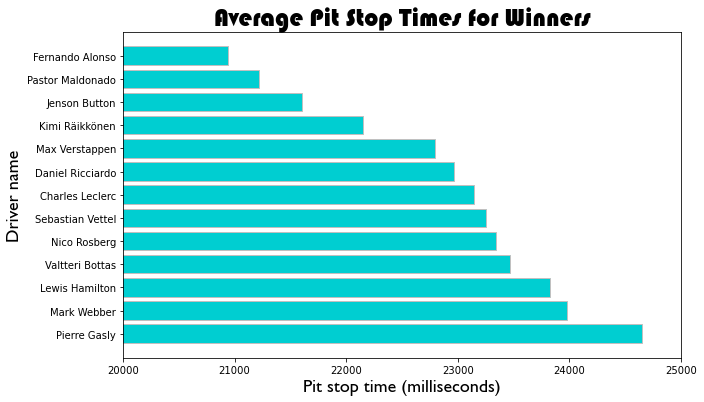

In [25]:
# build a bar chart for winners relating to pitstop times

bar1 = final_df.groupby(by='name').avg_ps_time.mean().reset_index()
bar1 = bar1.sort_values('avg_ps_time',ascending=False)

x = bar1.name
y = bar1.avg_ps_time

plt.figure(figsize=(10,6))
 
plt.title("Average Pit Stop Times for Winners", fontname='bauhaus 93', fontsize = 25)
plt.xlabel("Pit stop time (milliseconds)", fontname='gill sans mt', fontsize = 18)
plt.ylabel("Driver name", fontname='gill sans mt', fontsize = 18)
#plt.grid(color='gainsboro',alpha=.5)
plt.barh(x,y, color='darkturquoise', edgecolor='silver')
plt.xlim(20000,25000)
plt.savefig('output/APTbyWinner.png',pad_inches=.5)
plt.show()

In [6]:
# build a dataframe for pitstop analysis for just Lewis Hamilton

mask = pitresults_df.driverId == 1
lewis_df = pitresults_df.loc[mask,:]
# cleanup identifiably incorrect data
lewis_df.loc[3599,'milliseconds_pit'] = 18572.95
lewis_df.loc[4605,'milliseconds_pit'] = 18100.87
lewis_df.loc[5192,'milliseconds_pit'] = 16404.78
lewis_df.loc[5502,'milliseconds_pit'] = 33303.61
lewis_df.loc[5503,'milliseconds_pit'] = 24420.48
lewis_df.loc[5815,'milliseconds_pit'] = 21507.68
lewis_df.loc[7658,'milliseconds_pit'] = 25168.64
lewis_df.loc[7750,'milliseconds_pit'] = 23566.96
lewis_df.loc[7754,'milliseconds_pit'] = 21409.11
lewis_df.loc[3802,'points']=25
lewis_df.loc[3803,'points']=25
# remove 'nulls'
lewis_df = lewis_df.loc[lewis_df.milliseconds_result != '\\N',:]
lewis_df['total_race_time'] = lewis_df.milliseconds_result.astype(float)

# create the groupby data
lprep_df = lewis_df.groupby(by='raceId').stop.max().reset_index()
lprep_df2 = lewis_df.groupby(by='raceId').milliseconds_pit.sum().reset_index()
lprep_df3 = lewis_df.groupby(by='raceId').points.mean().reset_index()
lprep_df4 = lewis_df.groupby(by='raceId').driverId.mean().reset_index()
lprep_df5 = lewis_df.groupby(by='raceId').laps.mean().reset_index()
lprep_df6 = lewis_df.groupby(by='raceId').lap.min().reset_index()
lprep_df6['min_lap'] = lprep_df6.lap
lprep_df6 = lprep_df6.drop(['lap'], axis=1)
lprep_df7 = winner_df.groupby(by='raceId').lap.max().reset_index()
lprep_df7['max_lap'] = lprep_df7.lap
lprep_df7 = lprep_df7.drop(['lap'], axis=1)
lprep_df8 = lewis_df.groupby(by='raceId').total_race_time.mean().reset_index()
lprep_df9 = lewis_df.groupby(by='raceId').positionOrder.mean().reset_index()

lproject_df = pd.DataFrame()

# inject the groupby data into a new df
lproject_df['raceId'] = lprep_df.raceId
lproject_df['pitstops'] = lprep_df.stop
lproject_df['ps_milliseconds'] = lprep_df2.milliseconds_pit
lproject_df['points'] = lprep_df3.points
lproject_df['driverId'] = lprep_df4.driverId
lproject_df['laps'] = lprep_df5.laps
lproject_df['min_pitstop_lap'] = lprep_df6.min_lap
lproject_df['max_pitstop_lap'] = lprep_df7.max_lap
lproject_df['total_race_time'] =lprep_df8.total_race_time
lproject_df['avg_ps_time'] = lproject_df.ps_milliseconds / project_df.pitstops
lproject_df['percent_pitstop_time'] = lproject_df.ps_milliseconds / project_df.total_race_time
lproject_df['position'] = lprep_df9.positionOrder

# grab year data
raceclean_df = pd.DataFrame()
raceclean_df['raceId'] = races_df.raceId
raceclean_df['year'] = races_df.year

# add year data to df
final_lewis_df = pd.merge(lproject_df,raceclean_df,on='raceId')

# add driver names to df
final_lewis_df = pd.merge(final_lewis_df,driverclean_df,on='driverId')

# add winner y/n (1/0) to df
winner = []
for r in final_lewis_df.position:
    if r == 1:
        winner.append(1)
    else:
        winner.append(0)
final_lewis_df['winner']=winner

final_lewis_df

C:\Users\Tim\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,raceId,pitstops,ps_milliseconds,points,driverId,laps,min_pitstop_lap,max_pitstop_lap,total_race_time,avg_ps_time,percent_pitstop_time,position,year,name,winner
0,841,2,46426.00,18.0,1,58,16,36,5392556.0,23213.000000,0.008645,2,2011,Lewis Hamilton,0
1,842,4,93011.00,4.0,1,56,12,41,5929789.0,31003.666667,0.015873,8,2011,Lewis Hamilton,0
2,843,3,61978.00,25.0,1,56,15,38,5818226.0,20659.333333,0.010652,1,2011,Lewis Hamilton,1
3,844,4,99637.00,12.0,1,58,9,47,5457790.0,24909.250000,0.018391,4,2011,Lewis Hamilton,0
4,845,4,81457.00,18.0,1,66,11,48,5943931.0,20364.250000,0.013706,2,2011,Lewis Hamilton,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,1038,3,81482.64,7.0,1,53,20,20,6443301.0,81482.640000,0.016737,7,2020,Lewis Hamilton,0
168,1039,5,107757.07,26.0,1,59,7,46,8375060.0,21551.414000,0.017183,1,2020,Lewis Hamilton,1
169,1040,1,41352.00,15.0,1,53,16,48,5663093.0,20676.000000,0.007250,3,2020,Lewis Hamilton,0
170,1041,2,47163.00,25.0,1,60,16,21,5749641.0,47163.000000,0.009384,1,2020,Lewis Hamilton,1


In [7]:
# create a dataframe for Lewis Hamilton pitstop analysis by year

pprprep1 = final_lewis_df.groupby(by='year').points.sum().reset_index()
pprprep2 = final_lewis_df.groupby(by='year').raceId.count().reset_index()
pprprep3 = final_lewis_df.groupby(by='year').avg_ps_time.mean().reset_index()

ppr_df = pd.DataFrame()

ppr_df['year'] = pprprep1.year
ppr_df['points'] = pprprep1.points
ppr_df['races'] = pprprep2.raceId
ppr_df['avg_ps_time'] = pprprep3.avg_ps_time
ppr_df['ppr'] = pprprep1.points / pprprep2.raceId
ppr_df

,year,points,races,avg_ps_time,ppr
0,2011,227.0,16,27915.218750,14.187500
1,2012,190.0,14,21675.440476,13.571429
2,2013,189.0,17,33789.465686,11.117647
3,2014,359.0,16,26523.175521,22.437500
4,2015,381.0,18,26068.416667,21.166667
5,2016,380.0,19,35219.532632,20.000000
6,2017,361.0,19,26889.011930,19.000000
7,2018,408.0,20,21976.800000,20.400000
8,2019,413.0,21,30808.595238,19.666667
9,2020,256.0,12,35626.462833,21.333333


In [17]:
# correlation analysis
print(f'Correlation between LH avg ps time and ppr/year is: {ppr_df.avg_ps_time.corr(ppr_df.ppr)}')
print(f'Correlation between LH avg ps time and position is: {final_lewis_df.avg_ps_time.corr(final_lewis_df.position)}')
print(f'Correlation between LH avg ps time and points is: {final_lewis_df.avg_ps_time.corr(final_lewis_df.points)}')

Correlation between LH avg ps time and ppr/year is: 0.016543650214039952
Correlation between LH avg ps time and position is: 0.1848551203698254
Correlation between LH avg ps time and points is: -0.15863897411858352


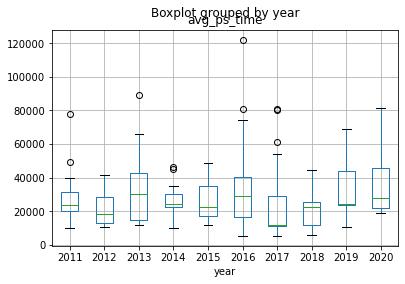

In [9]:
# understanding avg ps time by year
final_lewis_df.boxplot(column='avg_ps_time',by='year')
plt.show()

In [10]:
# building a dataframe to summarize Lewis Hamilton pitstop data here he is the race winner by year
winner_lewis_df=final_lewis_df.loc[final_lewis_df.position==1,:]

wlprep1 = winner_lewis_df.groupby(by='year').points.sum().reset_index()
wlprep2 = winner_lewis_df.groupby(by='year').raceId.count().reset_index()
wlprep3 = winner_lewis_df.groupby(by='year').avg_ps_time.mean().reset_index()

wl_df = pd.DataFrame()

wl_df['year'] = wlprep1.year
wl_df['points'] = wlprep1.points
wl_df['races'] = wlprep2.raceId
wl_df['avg_ps_time'] = wlprep3.avg_ps_time
wl_df['ppr'] = wlprep1.points / wlprep2.raceId
wl_df

,year,points,races,avg_ps_time,ppr
0,2011,75.0,3,20226.944444,25.000000
1,2012,100.0,4,18726.250000,25.000000
2,2013,25.0,1,32715.000000,25.000000
3,2014,275.0,11,27242.846212,25.000000
4,2015,250.0,10,23727.750000,25.000000
5,2016,250.0,10,30985.712833,25.000000
6,2017,225.0,9,26892.111111,25.000000
7,2018,275.0,11,24348.454545,25.000000
8,2019,279.0,11,28601.045455,25.363636
9,2020,203.0,8,31055.426750,25.375000


In [11]:
# building a dataframe to summarize Lewis Hamilton pitstop data for all races by year
alhprep1 = final_lewis_df.groupby(by='year').points.sum().reset_index()
alhprep2 = final_lewis_df.groupby(by='year').raceId.count().reset_index()
alhprep3 = final_lewis_df.groupby(by='year').avg_ps_time.mean().reset_index()

alh_df = pd.DataFrame()

alh_df['year'] = alhprep1.year
alh_df['points'] = alhprep1.points
alh_df['races'] = alhprep2.raceId
alh_df['avg_ps_time'] = alhprep3.avg_ps_time
alh_df['ppr'] = alhprep1.points / alhprep2.raceId
alh_df

,year,points,races,avg_ps_time,ppr
0,2011,227.0,16,27915.218750,14.187500
1,2012,190.0,14,21675.440476,13.571429
2,2013,189.0,17,33789.465686,11.117647
3,2014,359.0,16,26523.175521,22.437500
4,2015,381.0,18,26068.416667,21.166667
5,2016,380.0,19,35219.532632,20.000000
6,2017,361.0,19,26889.011930,19.000000
7,2018,408.0,20,21976.800000,20.400000
8,2019,413.0,21,30808.595238,19.666667
9,2020,256.0,12,35626.462833,21.333333


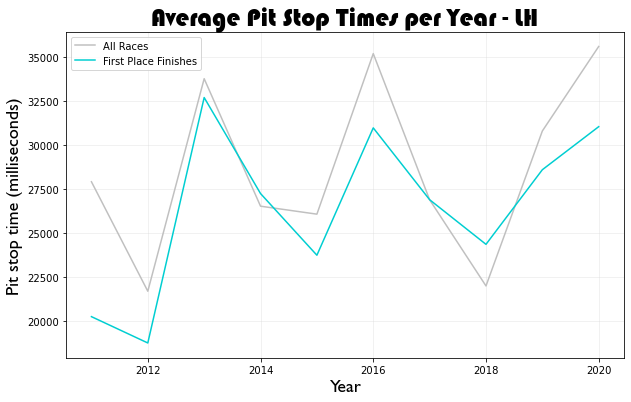

In [26]:
# project visualization of Lewis Hamilton pitstop info by year for all race and for races he won

plt.figure(figsize=(10,6))
plt.title("Average Pit Stop Times per Year - LH", fontname='bauhaus 93', fontsize = 25)
plt.ylabel("Pit stop time (milliseconds)", fontname='gill sans mt', fontsize = 18)
plt.xlabel("Year", fontname='gill sans mt', fontsize = 18)

plt.plot(alhprep1.year,alhprep3.avg_ps_time,c='silver', label='All Races')
#plt.scatter(wl_df.year,wl_df.avg_ps_time, s=wl_df.races*5,c='r')
plt.plot(wl_df.year,wl_df.avg_ps_time,c='darkturquoise', label='First Place Finishes')
plt.legend()
plt.grid(color='gainsboro',alpha=.5)

plt.savefig('output/APTLHbyYear.png')

plt.show()

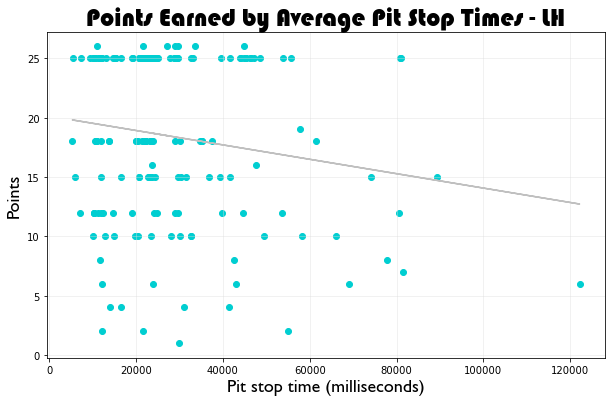

In [32]:
x = final_lewis_df.avg_ps_time
y = final_lewis_df.points

plt.figure(figsize=(10,6))
 
plt.title("Points Earned by Average Pit Stop Times - LH", fontname='bauhaus 93', fontsize = 25)
plt.xlabel("Pit stop time (milliseconds)", fontname='gill sans mt', fontsize = 18)
plt.ylabel("Points", fontname='gill sans mt', fontsize = 18)
plt.scatter(x,y, color='darkturquoise')
plt.grid(color='gainsboro',alpha=.5)

# Perform a linear regression on ps time vs points
ptp_slope, ptp_int, ptp_r, ptp_p, ptp_std_err = stats.linregress(final_lewis_df.avg_ps_time, final_lewis_df.points)
# Create equation of line to calculate predicted points
ptp_fit = ptp_slope * final_lewis_df.avg_ps_time + ptp_int
# plot linear regression
plt.plot(final_lewis_df.avg_ps_time,ptp_fit,color='silver')

plt.savefig('output/LHPointsByAPT.png')

plt.show()

In [35]:
stats.ttest_ind(final_lewis_df.avg_ps_time, final_lewis_df.points, equal_var=False)

Ttest_indResult(statistic=20.319831224749144, pvalue=1.8135378274230317e-47)

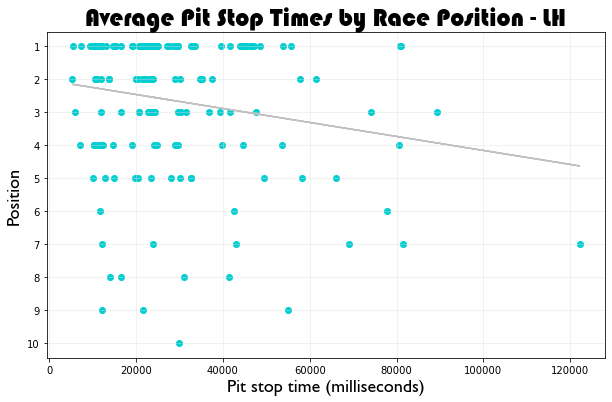

In [28]:
x = final_lewis_df.avg_ps_time
y = final_lewis_df.position

plt.figure(figsize=(10,6))
plt.title("Average Pit Stop Times by Race Position - LH", fontname='bauhaus 93', fontsize = 25)
plt.xlabel("Pit stop time (milliseconds)", fontname='gill sans mt', fontsize = 18)
plt.ylabel("Position", fontname='gill sans mt', fontsize = 18)
plt.scatter(x,y, color='darkturquoise')
plt.gca().invert_yaxis()
plt.yticks([1,2,3,4,5,6,7,8,9,10])
plt.grid(color='gainsboro',alpha=.5)

# Perform a linear regression on ps time vs position
ptp_slope, ptp_int, ptp_r, ptp_p, ptp_std_err = stats.linregress(final_lewis_df.avg_ps_time, final_lewis_df.position)
# Create equation of line to calculate predicted position
ptp_fit = ptp_slope * final_lewis_df.avg_ps_time + ptp_int
# plot linear regression
plt.plot(final_lewis_df.avg_ps_time,ptp_fit,color='silver')

plt.savefig('output/LHPositionByAPT.png')

plt.show()


In [29]:
stats.ttest_ind(final_lewis_df.avg_ps_time, final_lewis_df.position, equal_var=False)

Ttest_indResult(statistic=20.331049960023254, pvalue=1.6961802955854919e-47)